# Inspection of DC2 Object Table 
### Michael Wood-Vasey (@wmwv)

1. Make density plots (e.g., `hexbin`, `hist2d`, `datashader`) of 
    - r-i, g-r
    - u-g, g-r
    - u-z, g-r
    - z-y, g-r
    - ra, dec
2. Make 1D density plots (e.g., `hist`, kernel-density-estimation)
    - N({ugrizy})
    - Shape parameters

Verification:  
Compare GCR access and DPDD Parquet file.

In [1]:
# Insert development version of gcr-catalogs/issues/254
import sys
sys.path.insert(0, '/global/homes/w/wmwv/local/lsst/gcr-catalogs')

In [2]:
import os

import numpy as np
import pandas as pd

import GCRCatalogs

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [4]:
# cmap = 'Oranges'
cmap = 'viridis_r'

In [5]:
reader = 'dc2_object_run1.2p'

In [6]:
cat = GCRCatalogs.load_catalog(reader)

In [7]:
# The cat object knows about its base directory
# We'll look there for the Parquet file
dpdd_parquet_file = 'dpdd_{}.parquet'.format(reader)
dpdd_parquet_file = os.path.join(cat.base_dir, dpdd_parquet_file)

In [8]:
df = pd.read_parquet(dpdd_parquet_file)

In [9]:
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    plt.plot(model_gmr, model_rmi, **plot_kwargs)

In [10]:
def plot_color_color(z, color1, color2, range1=(-1, +2), range2=(-1, +2), bins=31):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['mag_%s' % band1] - z['mag_%s' % band2],
        z['mag_%s' % band3] - z['mag_%s' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi, cmap=cmap)
    plt.contour(xi, yi, zi)
    plt.xlabel('%s-%s' % (band1, band2))
    plt.ylabel('%s-%s' % (band3, band4))

    plot_stellar_locus(color1, color2)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


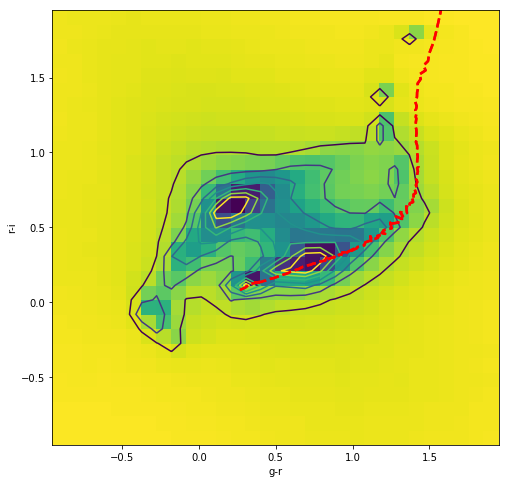

In [11]:
plot_color_color(df, 'gmr', 'rmi')
plot_stellar_locus('gmr', 'rmi')

DC2 Run 1.x Main region
https://docs.google.com/document/d/1aQOPL9smeDlhtlwDrp39Zuu2q8DKivDaHLQX3_omwOI/view

| Location        | RA (degrees) | Dec (degrees) |
|:--------------- |:------------ |:------------- |
Center            | 55.064       | -29.783
North-East Corner | 57.87        | -27.25
North-West Corner | 52.25        | -27.25
South-West Corner | 52.11        | -32.25
South-East Corner | 58.02        | -32.25

In [12]:
dc2_run1x_region = [[57.87, -27.25], [52.25, -27.25], [52.11, -32.25], [58.02, -32.25]]

In [13]:
region = Polygon(dc2_run1x_region)

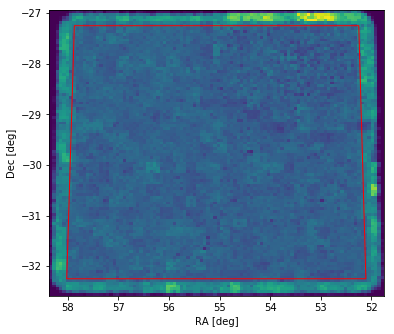

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1)

plt.hist2d(df['ra'], df['dec'], bins=100)
plt.xlim(plt.xlim()[::-1])  # Flip to East left
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
# plt.colorbar('objects / bin')

region = Polygon(dc2_run1x_region, color='red', fill=False)
ax.add_patch(region);
plt.savefig('DC2_Run1.2p_ra_dec.png')

In [ ]:
help(plt.hist2d)

In [ ]:
help(Polygon)